In [50]:
import json
import pandas as pd
from math import sin, sqrt
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns


replace = {
    'm_fwd': 'Alpha Forward',
    'm_rev': 'Alpha Reverse',
    'm_swr': 'Alpha SWR',
    'm_freq': 'Alpha Frequency',
    'm_temp': 'Alpha Temperature',
    't_fwd': 'MC-200 Forward',
    't_rev': 'MC-200 Reverse',
    't_swr': 'MC-200 SWR',
}


def load_file(*files: str):
    data = {}
    for filename in files:
        with open(filename) as f:
            for line in f.readlines():
                if line.startswith('//'):
                    continue

                d = json.loads(line)

                # drop all the metadata and the raw sample values
                record = {
                    **d['location'],
                    # **d['data'],
                }

                def sim(a, b):
                    diff = abs(a - b)
                    return (diff / a) * 100

                record['error_fwd'] = sim(d['data']['m_fwd'], d['data']['t_fwd'])
                record['error_rev'] = sim(d['data']['m_rev'], d['data']['t_rev'])
                record['error_swr'] = sim(d['data']['m_swr'], d['data']['t_swr'])

                for k, v in replace.items():
                    record[v] = d['data'][k]

                location = d['location']
                key = f"{location['ant']}:{location['freq']}:{location['power']}"
                data[key] = record

    df = pd.DataFrame.from_records(list(data.values()))

    return df


In [70]:
df = load_file('data.jsonl')
df = df.query('ant == 3')
df = df.query('freq == "14000000"')
# df = df.query('freq == "18068000"')
# df = df.query('freq == "10100000"')
# df = df.query('freq == "01800000"')
# df = df.query('power == "020"')
df = df.drop('Alpha Frequency', axis=1)
df = df.drop('Alpha Temperature', axis=1)
df['error_swr'] = df['error_swr'].apply(lambda x: f'{x:0.1f}%')
df['error_fwd'] = df['error_fwd'].apply(lambda x: f'{x:0.1f}%')
df['error_rev'] = df['error_rev'].apply(lambda x: f'{x:0.1f}%')
# df = df.sort_values('error_swr', ascending=False)
df = df.sort_values(['ant', 'freq', 'power'])

df = df.filter(['ant', 'freq', 'power', 'error_fwd', 'MC-200 Forward', 'Alpha Forward', 'error_rev', 'MC-200 Reverse', 'Alpha Reverse', 'error_swr', 'MC-200 SWR', 'Alpha SWR'], axis=1)
df

# df = df.filter(['error_fwd', 'error_rev', 'error_swr'], axis=1)
# df.median()
# df.mean()
# df.mode()

,ant,freq,power,error_fwd,MC-200 Forward,Alpha Forward,error_rev,MC-200 Reverse,Alpha Reverse,error_swr,MC-200 SWR,Alpha SWR
576,3,14000000,005,4.8%,5.001765,4.773737,41.8%,2.777627,1.958353,48.9%,6.849621,4.598856
577,3,14000000,010,1.4%,10.708216,10.564812,48.7%,6.185617,4.160586,67.0%,7.334616,4.392488
578,3,14000000,015,1.1%,14.677016,14.522639,48.0%,8.389746,5.668662,67.8%,7.198781,4.289974
579,3,14000000,020,0.6%,20.042057,19.918937,44.8%,11.175858,7.718243,64.1%,6.897010,4.201892
580,3,14000000,025,2.3%,26.282182,25.695593,43.4%,14.386447,10.034857,59.7%,6.688078,4.187596
581,3,14000000,030,3.2%,30.736522,29.784805,43.2%,16.603521,11.594656,57.5%,6.547095,4.155667
582,3,14000000,035,4.6%,36.161237,34.564197,42.2%,19.478593,13.701822,55.1%,6.517608,4.200919
583,3,14000000,040,4.7%,41.245663,39.396088,41.2%,22.078413,15.640942,53.6%,6.452690,4.201903
584,3,14000000,050,6.6%,51.515527,48.305631,39.4%,27.173065,19.492969,47.2%,6.306697,4.284040
585,3,14000000,060,6.4%,52.217181,49.075011,41.3%,27.692210,19.601073,50.0%,6.359494,4.238819


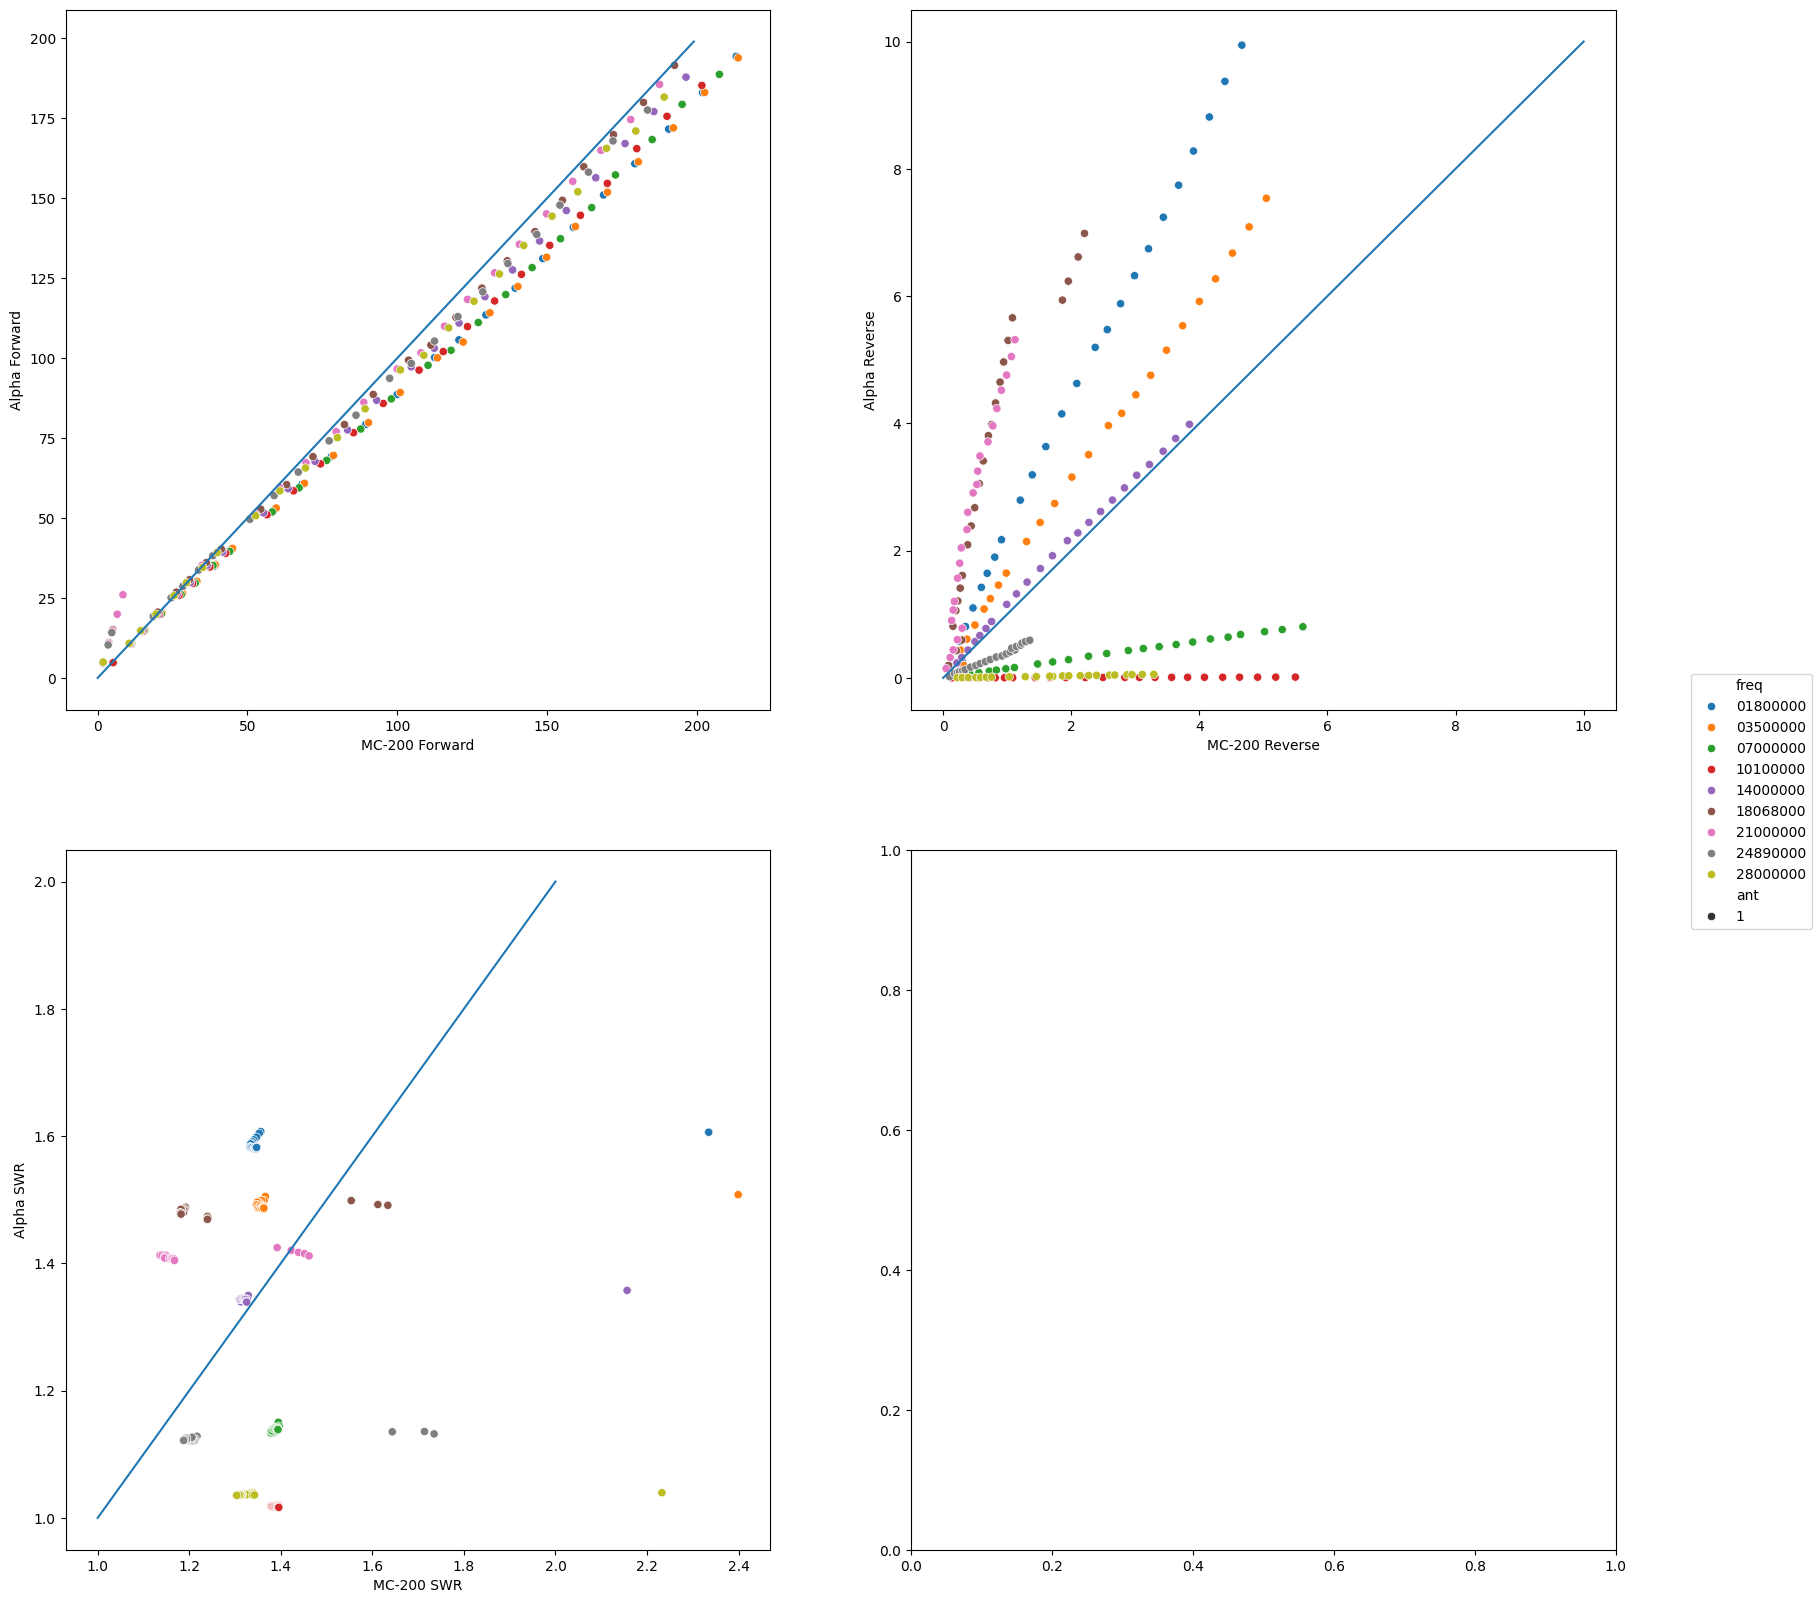

In [72]:
df = load_file('data.jsonl')

df = df.query('ant == 1')
df = df.query('freq != "50000000"')

fig, ax = plt.subplots(2, 2, figsize=(20, 20))


def make_line(a, *r):
    line = pd.DataFrame.from_records([{'x': i, 'y': i} for i in range(*r)])
    sns.lineplot(line, x='x', y='y', ax=a)


sns.scatterplot(df, x='MC-200 Forward', y='Alpha Forward', hue='freq', style='ant', ax=ax[0, 0])
make_line(ax[0, 0], 200)

sns.scatterplot(df, x='MC-200 Reverse', y='Alpha Reverse', hue='freq', style='ant', ax=ax[0, 1])
make_line(ax[0, 1], 11)

sns.scatterplot(df, x='MC-200 SWR', y='Alpha SWR', hue='freq', style='ant', ax=ax[1, 0])
make_line(ax[1, 0], 1, 3)

handles, labels = ax[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right')

ax[0, 0].get_legend().remove()
ax[0, 1].get_legend().remove()
ax[1, 0].get_legend().remove()
